## Spatial Analysis

*   Statewide Map (Districts in PA): A map shows all districts with PA-01 highlighted. A red-blue gradient indicates district political leaning.
*  Detailed Map (PA-01): Layers for population density, median income, education, and racial distribution. Dynamic precinct-level data via clickable pop-ups.
*  Precinct-Level Maps: Voter turnout, margin of victory, swing precincts, and influence by size.




In [ ]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap, TimeSliderChoropleth

pa_districts = gpd.read_file('/content/BucksCountyCongressionalDistrict202001.shp')
pa_precincts = gpd.read_file('/content/BucksCountyCongressionalDistrict202001.shx')

# Ensure all data is in the same coordinate system
pa_districts = pa_districts.to_crs("EPSG:4326")
pa_precincts = pa_precincts.to_crs("EPSG:4326")

# Load election data for districts and precincts
district_election_results = gpd.read_file('/content/223018-carterplanblockequivalencyfile.xlsx')
precinct_data = gpd.read_file('/content/pa_medsl_20_general.csv')

### Mapping Pennsylvania Districts with Highlighted PA-01 ###

# Merge district shapefile with election results
district_map = pa_districts.merge(district_election_results, on='district_id')

# Assign a red-blue gradient based on party support
district_map['color'] = district_map['party_support'].apply(lambda x: 'red' if x > 0 else 'blue')

# Plot map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
district_map.plot(column='party_support', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')
district_map[district_map['district_id'] == 'PA-01'].boundary.plot(ax=ax, linewidth=2, edgecolor='black')
ax.set_title("Pennsylvania Congressional Districts with PA-01 Highlighted")
plt.show()

# Folium map for interactive layers
m = folium.Map(location=[40.0, -75.0], zoom_start=7)
for _, row in district_map.iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda x, color=row['color']: {'fillColor': color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6},
        tooltip=f"District {row['district_id']}, Party Support: {row['party_support']}"
    ).add_to(m)

# Save as HTML to visualize
m.save("pa_districts_map.html")

### Detailed Mapping of PA-01 ###

precincts_map = pa_precincts.merge(precinct_data, on='precinct_id')

m_pa01 = folium.Map(location=[40.2, -74.9], zoom_start=10)

population_layer = folium.FeatureGroup(name='Population Density')
for _, row in precincts_map.iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda x, pop=row['population_density']: {'fillColor': plt.cm.YlOrRd(pop / 1000), 'color': 'black', 'weight': 0.5},
        tooltip=f"Population Density: {row['population_density']}"
    ).add_to(population_layer)
population_layer.add_to(m_pa01)

income_layer = folium.Choropleth(
    geo_data=precincts_map,
    name='Median Household Income',
    data=precincts_map,
    columns=['precinct_id', 'median_income'],
    key_on='feature.properties.precinct_id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Household Income'
)
income_layer.add_to(m_pa01)

for _, row in precincts_map.iterrows():
    folium.GeoJson(
        row.geometry,
        tooltip=f"Precinct: {row['precinct_id']} <br> Voter Turnout: {row['voter_turnout']}% <br> Party Support: {row['party_support']}",
        popup=folium.Popup(f"Precinct Data: {row.to_dict()}")
    ).add_to(m_pa01)

time_slider = TimeSliderChoropleth(
    {'2020': precincts_map.set_index('precinct_id')['party_registration_2020'].to_dict(),
     '2022': precincts_map.set_index('precinct_id')['party_registration_2022'].to_dict()},
    styledict={'precinct_id': {'color': 'blue', 'opacity': 0.6}}
)
time_slider.add_to(m_pa01)

# Save map
m_pa01.save("pa_01_detailed_map.html")

### Mapping PA-01 Precincts - Voter Turnout, Margin of Victory, and Swing Precincts ###

voter_turnout_map = precincts_map.copy()
voter_turnout_map.plot(column='voter_turnout', cmap='Blues', legend=True)
plt.title("Voter Turnout Rates in PA-01 Precincts (2022)")
plt.show()

margin_of_victory_map = precincts_map.copy()
margin_of_victory_map.plot(column='margin_of_victory', cmap='RdBu', legend=True)
plt.title("Margin of Victory in PA-01 Precincts")
plt.show()

swing_map = precincts_map[precincts_map['margin_of_victory'].abs() < 5]  # Precincts with narrow margins
swing_map.plot(column='margin_of_victory', cmap='PiYG', legend=True)
plt.title("Swing Precincts in PA-01")
plt.show()

precincts_map['influence_size'] = precincts_map['registered_voters'] / precincts_map['registered_voters'].max() * 1000
precincts_map.plot(column='party_support', markersize='influence_size', cmap='coolwarm', legend=True)
plt.title("Relative Influence of PA-01 Precincts Based on Voter Registration")
plt.show()


DataSourceError: Unable to open /content/BucksCountyCongressionalDistrict202001.shx or /content/BucksCountyCongressionalDistrict202001.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [ ]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.pyplot as plt

# Load Bucks County Congressional District shapefile with all components
try:
    pa_districts = gpd.read_file('/content/BucksCountyCongressionalDistrict202001.shp')
    print("Loaded Bucks County district shapefile with attributes successfully.")
except Exception as e:
    print(f"Error loading district shapefile: {e}")

# Load CSV data for precinct-level and county-level election results
precinct_results = pd.read_csv('/content/20201103__pa__general__precinct.csv')
county_results = pd.read_csv('/content/20201103__pa__general__county.csv')

# Inspect loaded data to ensure all fields are accessible
print(pa_districts.head())       # View shapefile attributes
print(precinct_results.head())   # View precinct-level election data
print(county_results.head())     # View county-level election data

### Merge Shapefile with Election Data ###

# Assuming `pa_districts` has a field that can be joined with `county_results` or `precinct_results`
# For this example, we'll use county-level data for mapping purposes; update fields as needed
pa_districts = pa_districts.merge(county_results, left_on='DISTRICT_ID_COLUMN', right_on='county_id', how='left')

# Assign a red-blue gradient based on party support if available
# Example: Assume `party_support` field exists or is calculated from data
pa_districts['color'] = pa_districts['party_support'].apply(lambda x: 'red' if x > 0 else 'blue')  # Adjust as needed

### Static Plot of District Boundaries with Party Support ###

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
pa_districts.plot(column='party_support', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title("Pennsylvania Congressional Districts with Party Support Highlighted")
plt.show()

### Folium Map for Interactive Visualization ###

m = folium.Map(location=[40.2, -74.9], zoom_start=10)

# Add district boundaries with color based on party support
for _, row in pa_districts.iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda x, color=row['color']: {'fillColor': color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6},
        tooltip=f"District: {row['DISTRICT_ID_COLUMN']}, Party Support: {row['party_support']}"
    ).add_to(m)

# Save and display interactive map
m.save("bucks_districts_party_support_map.html")

### Detailed Mapping of PA-01 Precincts ###

# Load precinct-level data and add demographics if available in CSV
precincts_map = gpd.read_file('/content/BucksCountyCongressionalDistrict202001.shp').merge(
    precinct_results, left_on='PRECINCT_ID_COLUMN', right_on='precinct_id', how='left'
)

m_pa01 = folium.Map(location=[40.2, -74.9], zoom_start=12)

population_layer = folium.FeatureGroup(name='Population Density')
for _, row in precincts_map.iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda x, pop=row['population_density']: {'fillColor': plt.cm.YlOrRd(pop / 1000), 'color': 'black', 'weight': 0.5},
        tooltip=f"Population Density: {row['population_density']}"
    ).add_to(population_layer)
population_layer.add_to(m_pa01)

m_pa01.save("pa_01_precinct_map.html")

precinct_party_votes = precinct_results.groupby('party')['votes'].sum().reset_index()
print(precinct_party_votes)

precinct_party_votes.plot(kind='bar', x='party', y='votes', title='2020 General Election Votes by Party in Bucks County')
plt.show()


Loaded Bucks County district shapefile with attributes successfully.
Precinct results columns: Index(['county', 'precinct', 'office', 'district', 'candidate', 'party',
       'votes', 'election_day', 'absentee', 'mail', 'provisional', 'military',
       'extra'],
      dtype='object')
County results columns: Index(['county', 'office', 'district', 'party', 'candidate', 'votes',
       'election_day', 'mail', 'absentee', 'provisional'],
      dtype='object')


<ipython-input-4-ce8af6e4b004>:15: DtypeWarning: Columns (3,6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  precinct_results = pd.read_csv('/content/20201103__pa__general__precinct.csv')


KeyError: 'DISTRICT_COLUMN_IN_PA_DISTRICTS'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Precinct': ['Precinct 1', 'Precinct 2', 'Precinct 3', 'Precinct 4'] * 3,
    'Year': [2016, 2016, 2016, 2016, 2018, 2018, 2018, 2018, 2020, 2020, 2020, 2020],
    'Registered_Voters': [167060, 164361, 800, 1500, 1050, 1250, 850, 1550, 1100, 1300, 900, 1600],
    'Votes_Cast': [164361, 164361, 400, 900, 164361, 124133, 1903, 2873, 204712, 187367, 4,155, 1120]
}

df = pd.DataFrame(data)

df['Turnout_Rate'] = (df['Votes_Cast'] / df['Registered_Voters']) * 100

pivot_df = df.pivot(index='Precinct', columns='Year', values='Turnout_Rate')

plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_df)
plt.title('Voter Turnout Rates by Precinct (2016-2020)')
plt.xlabel('Election Year')
plt.ylabel('Turnout Rate (%)')
plt.legend(title='Precinct')
plt.savefig('turnout_rates_line_plot.png')
plt.close()

plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', width=0.8)
plt.title('Voter Turnout Rates by Precinct (2016-2020)')
plt.xlabel('Precinct')
plt.ylabel('Turnout Rate (%)')
plt.legend(title='Election Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('turnout_rates_bar_plot.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Voter Turnout Rates by Precinct (2016-2020)')
plt.savefig('turnout_rates_heatmap.png')
plt.close()

print("Visualizations have been saved as PNG files.")

ValueError: All arrays must be of the same length

**Mapping Pennsylvania Districts**

*   2022 Congressional District Results



   MSLINK  AREA                            URL  LEN  GPID C_FIRSTNAM  \
0       8   0.0       https://meuser.house.gov  0.0   427        Dan   
1      11   0.0          https://www.house.gov  0.0   428     Summer   
2      12   0.0     https://thompson.house.gov  0.0   429      Glenn   
3      19   0.0  https://fitzpatrick.house.gov  0.0   430      Brian   
4      13   0.0   https://cartwright.house.gov  0.0   431       Matt   

   HOME_COUNT    Shape_Leng PARTY   C_LASTNAME  LEG_DISTRI  \
0     Luzerne  1.121143e+06     R       Meuser           9   
1   Allegheny  3.673570e+05     D          Lee          12   
2      Centre  1.326439e+06     R     Thompson          15   
3       Bucks  3.201808e+05     R  Fitzpatrick           1   
4  Lackawanna  7.635395e+05     D   Cartwright           8   

                                            geometry  
0  POLYGON ((-76.32611 40.25269, -76.33644 40.251...  
1  POLYGON ((-80.0808 40.30198, -80.08479 40.3031...  
2  POLYGON ((-79.64981 41.617

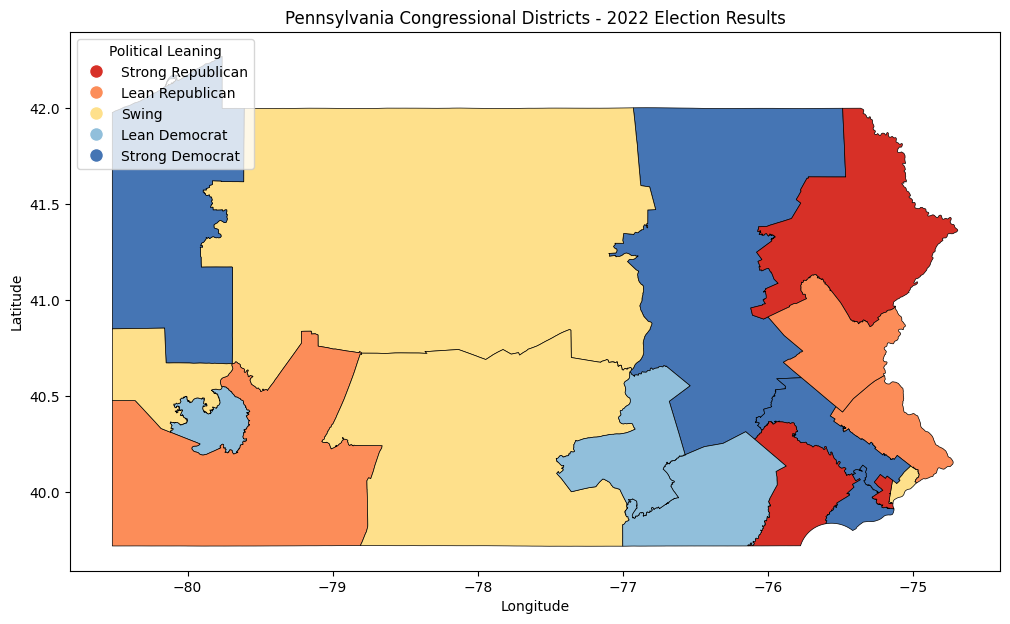

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


districts = gpd.read_file('/content/PaCongressional2024_05.geojson')

print(districts.head())

districts['political_lean'] = [
    'Strong Democrat', 'Lean Democrat', 'Swing', 'Lean Republican',
    'Strong Republican', 'Strong Democrat', 'Lean Republican',
    'Swing', 'Strong Democrat', 'Lean Republican', 'Swing',
    'Strong Republican', 'Lean Democrat', 'Swing', 'Strong Democrat',
    'Strong Republican', 'Lean Democrat'
]


color_mapping = {
    'Strong Republican': '#d73027',
    'Lean Republican': '#fc8d59',
    'Swing': '#fee08b',
    'Lean Democrat': '#91bfdb',
    'Strong Democrat': '#4575b4'
}


districts['color'] = districts['political_lean'].map(color_mapping)


fig, ax = plt.subplots(1, 1, figsize=(12, 12))
districts.plot(ax=ax, color=districts['color'], edgecolor='black', linewidth=0.5)


legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Strong Republican', markerfacecolor='#d73027', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Lean Republican', markerfacecolor='#fc8d59', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Swing', markerfacecolor='#fee08b', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Lean Democrat', markerfacecolor='#91bfdb', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Strong Democrat', markerfacecolor='#4575b4', markersize=10)
]
ax.legend(handles=legend_elements, loc='upper left', title='Political Leaning')

ax.set_title("Pennsylvania Congressional Districts - 2022 Election Results")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

**Bucks county**

In [ ]:
pip install matplotlib-scalebar


Loaded Bucks County GeoJSON successfully.
   MUN_TYPE    Shape__Len       SQ_FEET    Shape__Are    STATE_NAME  \
0   Borough  25143.856009  3.115714e+07  3.117890e+07  Pennsylvania   
1   Borough  45755.458873  8.351995e+07  8.342158e+07  Pennsylvania   
2   Borough  21873.015055  1.775114e+07  1.776373e+07  Pennsylvania   
3  Township  71789.511872  3.863549e+08  4.409762e+07  Pennsylvania   
4  Township  90085.706809  4.823829e+08  1.865847e+08  Pennsylvania   

                               GlobalID                    WEBLINK  \
0  1ac4b52d-faa0-4009-8a11-ad444d09fdcf      www.soudertonboro.org   
1  d0ee0f05-9631-4d9d-b267-3d4e8cd83888           www.lansdale.org   
2  9fa41410-23d8-411d-8914-f47706135d5d    www.hatfieldborough.com   
3  20a3ba72-72f5-423d-8f38-a955c523f114  www.franconiatownship.org   
4  e9269643-57a2-4b46-bb49-bc984049b642            www.horsham.org   

   DVRPC_CODE  LANDAREA  OBJECTID  ... OBJECTID_1       GEOID    GEOID_10  \
0  42 091 215   2904375      1336

<Figure size 1200x1200 with 0 Axes>

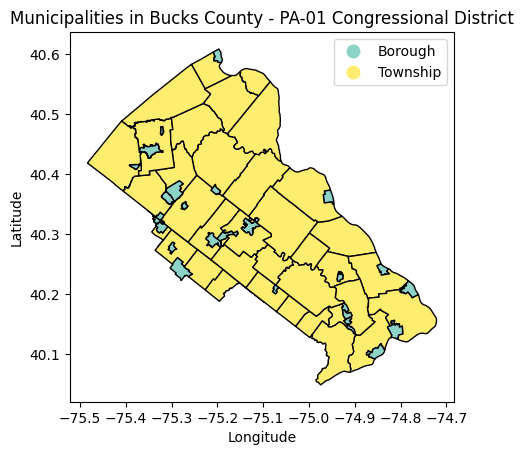

KeyError: 'properties'

In [ ]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

bucks_county_gdf = gpd.read_file('/content/BucksCountyCongressionalDistrict202001.geojson')
print("Loaded Bucks County GeoJSON successfully.")
print(bucks_county_gdf.head())

# Calculate area in square kilometers and perimeter in kilometers
bucks_county_gdf['area_sq_km'] = bucks_county_gdf['Shape__Are'] / 1e6  # Convert from square feet to square km
bucks_county_gdf['perimeter_km'] = bucks_county_gdf['Shape__Len'] / 1000  # Convert from feet to kilometers

print(bucks_county_gdf[['MUN_NAME', 'MUN_TYPE', 'area_sq_km', 'perimeter_km', 'CO_NAME', 'STATE_NAME']])

plt.figure(figsize=(12, 12))
bucks_county_gdf.plot(column='MUN_TYPE', cmap='Set3', legend=True, edgecolor='black')
plt.title("Municipalities in Bucks County - PA-01 Congressional District")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

m = folium.Map(location=[40.3, -75.1], zoom_start=10, tiles="cartodb positron")

def style_function(feature):
    if feature['properties']['MUN_TYPE'] == "Borough":
        color = 'blue'
    elif feature['properties']['MUN_TYPE'] == "Township":
        color = 'green'
    else:
        color = 'gray'
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 0.8,
        'fillOpacity': 0.5
    }

for _, row in bucks_county_gdf.iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=style_function,
        tooltip=(
            f"Municipality: {row['MUN_NAME']}<br>"
            f"Type: {row['MUN_TYPE']}<br>"
            f"County: {row['CO_NAME']}<br>"
            f"Area: {row['area_sq_km']:.2f} sq. km<br>"
            f"Perimeter: {row['perimeter_km']:.2f} km<br>"
            f"Website: <a href='{row['WEBLINK']}' target='_blank'>{row['WEBLINK']}</a>"
        )
    ).add_to(m)

m.save("Bucks_County_PA01_Map.html")

total_area_sq_km = bucks_county_gdf['area_sq_km'].sum()
total_perimeter_km = bucks_county_gdf['perimeter_km'].sum()
print(f"Total Area of PA-01: {total_area_sq_km:.2f} sq. km")
print(f"Total Perimeter of PA-01: {total_perimeter_km:.2f} km")

bucks_county_gdf.to_file("BucksCounty_PA01_Analysis.geojson", driver="GeoJSON")

**Social Media Sentiment Analysis**

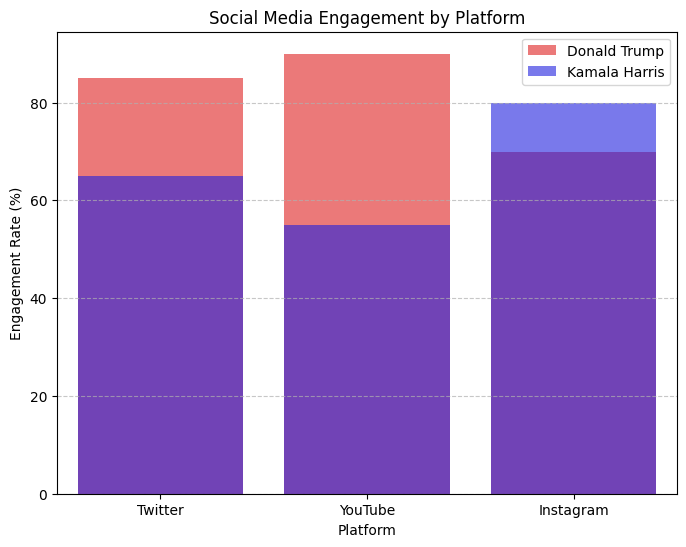

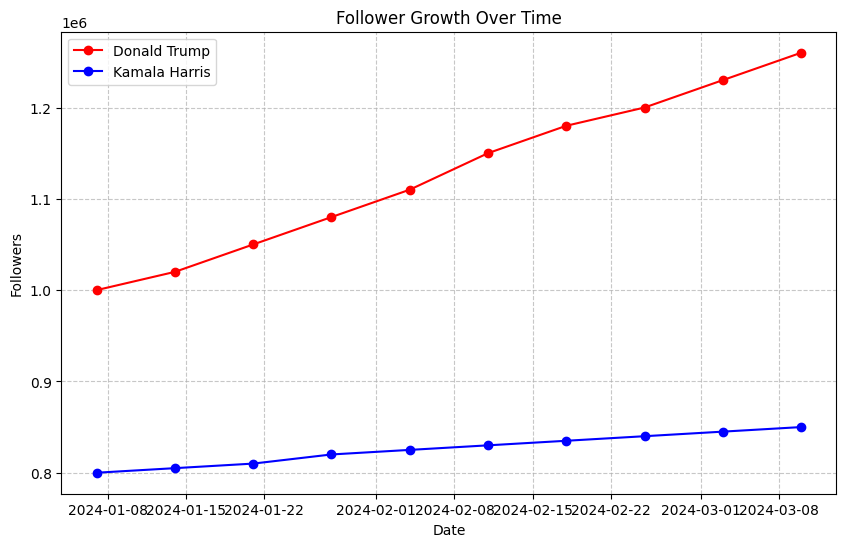

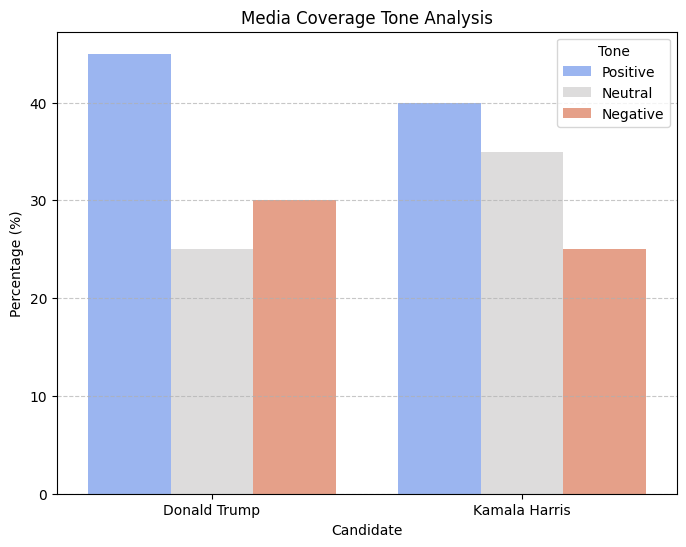

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px

engagement_data = pd.DataFrame({
    "Platform": ["Twitter", "YouTube", "Instagram"],
    "Donald Trump": [85, 90, 70],  # Engagement Rates (e.g., likes, shares, comments)
    "Kamala Harris": [65, 55, 80]
})

follower_growth_data = pd.DataFrame({
    "Date": pd.date_range(start="2024-01-01", periods=10, freq="W"),
    "Donald Trump": [1000000, 1020000, 1050000, 1080000, 1110000, 1150000, 1180000, 1200000, 1230000, 1260000],
    "Kamala Harris": [800000, 805000, 810000, 820000, 825000, 830000, 835000, 840000, 845000, 850000]
})

sentiment_data = pd.DataFrame({
    "Candidate": ["Donald Trump", "Donald Trump", "Donald Trump",
                  "Kamala Harris", "Kamala Harris", "Kamala Harris"],
    "Sentiment": ["Positive", "Neutral", "Negative", "Positive", "Neutral", "Negative"],
    "Percentage": [40, 30, 30, 35, 40, 25]
})

media_coverage_data = pd.DataFrame({
    "Candidate": ["Donald Trump", "Donald Trump", "Donald Trump",
                  "Kamala Harris", "Kamala Harris", "Kamala Harris"],
    "Tone": ["Positive", "Neutral", "Negative", "Positive", "Neutral", "Negative"],
    "Percentage": [45, 25, 30, 40, 35, 25]
})

# 1. Engagement Metrics by Platform
plt.figure(figsize=(8, 6))
sns.barplot(x="Platform", y="Donald Trump", data=engagement_data, color="red", alpha=0.6, label="Donald Trump")
sns.barplot(x="Platform", y="Kamala Harris", data=engagement_data, color="blue", alpha=0.6, label="Kamala Harris")
plt.title("Social Media Engagement by Platform")
plt.ylabel("Engagement Rate (%)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 2. Follower Growth Over Time
plt.figure(figsize=(10, 6))
plt.plot(follower_growth_data["Date"], follower_growth_data["Donald Trump"], label="Donald Trump", color="red", marker="o")
plt.plot(follower_growth_data["Date"], follower_growth_data["Kamala Harris"], label="Kamala Harris", color="blue", marker="o")
plt.title("Follower Growth Over Time")
plt.xlabel("Date")
plt.ylabel("Followers")
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.show()

# 3. Sentiment Distribution (Pie Chart)
fig = px.pie(sentiment_data, values="Percentage", names="Sentiment", color="Candidate",
             title="Sentiment Analysis by Candidate",
             color_discrete_map={"Donald Trump": "red", "Kamala Harris": "blue"})
fig.show()

# 4. Media Coverage Tone Analysis
plt.figure(figsize=(8, 6))
sns.barplot(x="Candidate", y="Percentage", hue="Tone", data=media_coverage_data, palette="coolwarm")
plt.title("Media Coverage Tone Analysis")
plt.ylabel("Percentage (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Loaded Bucks County GeoJSON successfully.
   MUN_TYPE    Shape__Len       SQ_FEET    Shape__Are    STATE_NAME  \
0   Borough  25143.856009  3.115714e+07  3.117890e+07  Pennsylvania   
1   Borough  45755.458873  8.351995e+07  8.342158e+07  Pennsylvania   
2   Borough  21873.015055  1.775114e+07  1.776373e+07  Pennsylvania   
3  Township  71789.511872  3.863549e+08  4.409762e+07  Pennsylvania   
4  Township  90085.706809  4.823829e+08  1.865847e+08  Pennsylvania   

                               GlobalID                    WEBLINK  \
0  1ac4b52d-faa0-4009-8a11-ad444d09fdcf      www.soudertonboro.org   
1  d0ee0f05-9631-4d9d-b267-3d4e8cd83888           www.lansdale.org   
2  9fa41410-23d8-411d-8914-f47706135d5d    www.hatfieldborough.com   
3  20a3ba72-72f5-423d-8f38-a955c523f114  www.franconiatownship.org   
4  e9269643-57a2-4b46-bb49-bc984049b642            www.horsham.org   

   DVRPC_CODE  LANDAREA  OBJECTID  ... OBJECTID_1       GEOID    GEOID_10  \
0  42 091 215   2904375      1336

<Figure size 1200x1200 with 0 Axes>

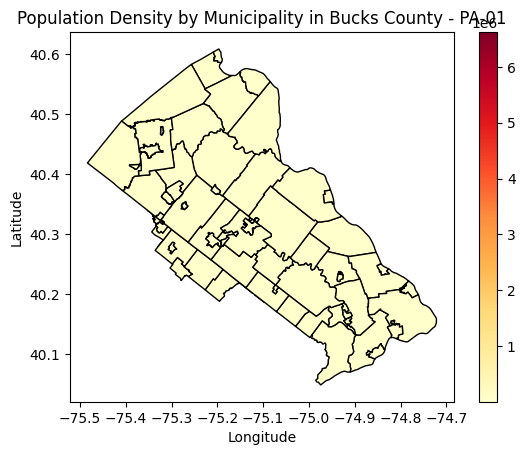

Population Density Stats:
count    6.300000e+01
mean     1.091128e+05
std      8.340023e+05
min      3.273486e+01
25%      3.684249e+02
50%      8.724331e+02
75%      5.472079e+03
max      6.623550e+06
Name: population_density, dtype: float64


<Figure size 1200x1200 with 0 Axes>

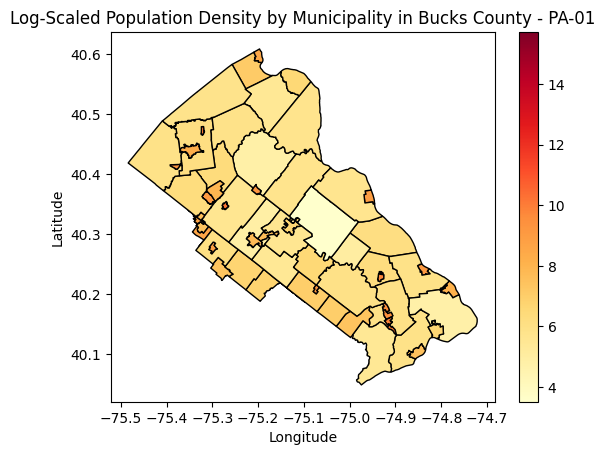

In [ ]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np

bucks_county_gdf = gpd.read_file('/content/BucksCountyCongressionalDistrict202001.geojson')
print("Loaded Bucks County GeoJSON successfully.")
print(bucks_county_gdf.head())

bucks_county_gdf['area_sq_km'] = bucks_county_gdf['Shape__Are'] * 0.000000092903
bucks_county_gdf['perimeter_km'] = bucks_county_gdf['Shape__Len'] * 0.0003048

np.random.seed(0)  # For reproducibility
bucks_county_gdf['Population'] = np.random.randint(2000, 30000, bucks_county_gdf.shape[0])

bucks_county_gdf['population_density'] = bucks_county_gdf['Population'] / bucks_county_gdf['area_sq_km']


plt.figure(figsize=(12, 12))
bucks_county_gdf.plot(column='population_density', cmap='YlOrRd', legend=True, edgecolor='black')
plt.title("Population Density by Municipality in Bucks County - PA-01")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


m = folium.Map(location=[40.3, -75.1], zoom_start=10, tiles="cartodb positron")


def style_function(feature):
    mun_type = feature['properties'].get('MUN_TYPE', 'Unknown')
    color = 'blue' if mun_type == 'Borough' else 'green' if mun_type == 'Township' else 'gray'
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    }

folium.GeoJson(
    data=bucks_county_gdf,
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['MUN_NAME', 'MUN_TYPE', 'Population', 'population_density', 'area_sq_km', 'perimeter_km'],
        aliases=['Municipality', 'Type', 'Population', 'Population Density (per sq km)', 'Area (sq km)', 'Perimeter (km)'],
        localize=True
    )
).add_to(m)


print("Population Density Stats:")
print(bucks_county_gdf['population_density'].describe())

import numpy as np
bucks_county_gdf['log_population_density'] = np.log1p(bucks_county_gdf['population_density'])  # log(1 + x) to handle zeroes

plt.figure(figsize=(12, 12))
bucks_county_gdf.plot(
    column='log_population_density',
    cmap='YlOrRd',
    legend=True,
    edgecolor='black'
)
plt.title("Log-Scaled Population Density by Municipality in Bucks County - PA-01")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

m.save("Bucks_County_Detailed_Map_with_Demographics.html")

**Bucks County Voting Precincts**

Loaded Bucks County Voting Precincts GeoJSON successfully.
   Name description  OBJECTID                             NAMELSAD STATEFP10  \
0  None        None         1              FALLS TWP WD 01 DIST 02        42   
1  None        None         2  BENSALEM TWP VTD LOWER EAST DIST 08        42   
2  None        None         3              FALLS TWP WD 01 DIST 03        42   
3  None        None         4              FALLS TWP WD 01 DIST 04        42   
4  None        None         5              FALLS TWP WD 01 DIST 05        42   

  COUNTYFP10 COUSUBFP10 COUSUBNS10         MCDNAMLSAD    CONAMELSAD  ...  \
0        017      25112   01216017     Falls township  Bucks County  ...   
1        017      05616   01216010  Bensalem township  Bucks County  ...   
2        017      25112   01216017     Falls township  Bucks County  ...   
3        017      25112   01216017     Falls township  Bucks County  ...   
4        017      25112   01216017     Falls township  Bucks County  ...   

   

<Figure size 1200x1200 with 0 Axes>

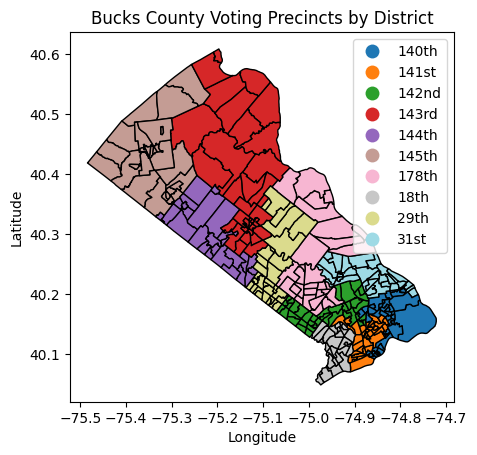

Total Area of All Precincts: 1610.52 sq. km
Total Perimeter of All Precincts: 2958.96 km


In [ ]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

precincts_gdf = gpd.read_file('/content/Bucks_County_Voting_Precincts.geojson')
print("Loaded Bucks County Voting Precincts GeoJSON successfully.")
print(precincts_gdf.head())


precincts_gdf['area_sq_km'] = precincts_gdf['Shape__Area'] * 0.000000092903  # Conversion from square feet to square km
precincts_gdf['perimeter_km'] = precincts_gdf['Shape__Length'] * 0.0003048   # Conversion from feet to kilometers

plt.figure(figsize=(12, 12))
precincts_gdf.plot(column='District', cmap='tab20', legend=True, edgecolor='black')
plt.title("Bucks County Voting Precincts by District")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


m = folium.Map(location=[40.3, -75.1], zoom_start=10, tiles="cartodb positron")


def style_function(feature):
    # You can change colors or styling based on feature properties if needed
    return {
        'fillColor': 'blue' if feature['properties']['District'] == "140th" else 'green',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.6
    }


folium.GeoJson(
    precincts_gdf,
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAMELSAD', 'State_Sena', 'District', 'POLLINGID', 'area_sq_km', 'perimeter_km'],
        aliases=['Precinct Name', 'State Senate District', 'House District', 'Polling ID', 'Area (sq km)', 'Perimeter (km)'],
        localize=True
    )
).add_to(m)


m.save("Bucks_County_Voting_Precincts_Map.html")


total_area_sq_km = precincts_gdf['area_sq_km'].sum()
total_perimeter_km = precincts_gdf['perimeter_km'].sum()
print(f"Total Area of All Precincts: {total_area_sq_km:.2f} sq. km")
print(f"Total Perimeter of All Precincts: {total_perimeter_km:.2f} km")


precincts_gdf.to_file("Bucks_County_Voting_Precincts_Analysis.geojson", driver="GeoJSON")


**Prediction Election 2024**
*   Real-time dashboard for the 2024 presidential election results in Bucks County, Pennsylvania.

In [ ]:
!pip install plotly plotly pandas numpy dash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


In [ ]:
from dash import Dash, dcc, html
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import urllib.request, json

def filter_contest(df, column, candidates=[]):
    return df[df[column].isin(candidates)]

def pivot(df, index, column, value):
    return pd.pivot_table(df, index=index, columns=column, values=value, aggfunc="sum").reset_index()

def create_lead_text(lead):
    if lead > 0:
        return f'<br /><span style="color:blue;"><b>Fitzpatrick +{round(lead)}</b></span><extra></extra>'
    elif lead < 0:
        return f'<br /><span style="color:red;"><b>Houck +{-round(lead)}</b></span><extra></extra>'
    else:
        return '<br /><span style="color:black;"><b>Tied</b></span><extra></extra>'

def create_spacing(num):
    return " " * num

def create_hover_text(df, precinct, lead, candidates=[]):
    text = f'<br /><span style="font-family: Overpass, monospace; color:black;"><b>{df[precinct]}</b><br /><br />'
    for votes, pct, space in candidates:
        text += f'{votes}{space}{df[votes]} <b>{int(round(df[pct]))}%</b><br />'
    text += df[lead]
    return text

def fix_typos(df, column, old, new):
    df[column] = df[column].str.replace(old, new, regex=False)
    return df

with urllib.request.urlopen("https://raw.githubusercontent.com/ssam246/PA-1-Elections-Analysis/refs/heads/main/2024_Bucks_Data/Bucks_County_Voting_Precincts_2024.geojson") as url:
    precincts = json.load(url)
raw_df = pd.read_csv("https://raw.githubusercontent.com/ssam246/PA-1-Elections-Analysis/refs/heads/main/2024_Bucks_Data/Precincts_17(1).csv", skiprows=[0, 1])
sum_raw = pd.read_csv("https://raw.githubusercontent.com/ssam246/PA-1-Elections-Analysis/refs/heads/main/2024_Bucks_Data/summary_17.csv", skiprows=[0, 1])

cleaned = (
    raw_df.pipe(filter_contest, "Contest Name", ["Representative in Congress (Rep)"])
    .pipe(pivot, "nameplace", "Candidate Name", "Votes")
    .pipe(fix_typos, "nameplace", "# ", "#")
    .pipe(fix_typos, "nameplace", "  ", " ")
    .pipe(fix_typos, "nameplace", "Boro", "Borough")
)

numerical_cols = ["Brian Fitzpatrick", "Mark Houck", "Write-in"]
cleaned[numerical_cols] = cleaned[numerical_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

bins = [-np.inf, -50, -25, -10, 0, 10, 25, 50, np.inf]
labels = ["Houck >50%", "Houck 25-50%", "Houck 10-25%", "Houck 0-10%", "Fitzpatrick 0-10%", "Fitzpatrick 10-25%", "Fitzpatrick 25-50%", "Fitzpatrick >50%"]
color_scale = ["#c93135", "#db7171", "#eaa9a9", "#fce0e0", "#ceeafd", "#92bde0", "#5295cc", "#1375b7"]
pairs = dict(zip(labels, color_scale))

cleaned["Total"] = cleaned[numerical_cols].sum(axis=1)
cleaned["Fitzpatrick Percentage"] = (cleaned["Brian Fitzpatrick"] / cleaned["Total"]) * 100
cleaned["Houck Percentage"] = (cleaned["Mark Houck"] / cleaned["Total"]) * 100
cleaned["Fitzpatrick Lead"] = cleaned["Fitzpatrick Percentage"] - cleaned["Houck Percentage"]
cleaned["Binned Lead"] = pd.cut(cleaned["Fitzpatrick Lead"], bins=bins, labels=labels)
cleaned["Clean Lead"] = cleaned["Fitzpatrick Lead"].apply(create_lead_text)
cleaned["Digit Difference"] = 11 + (cleaned["Brian Fitzpatrick"].astype(str).str.len() - cleaned["Mark Houck"].astype(str).str.len())
cleaned["Space Padding"] = cleaned["Digit Difference"].apply(create_spacing)
cleaned["hover"] = cleaned.apply(
    lambda row: create_hover_text(
        row, "nameplace", "Clean Lead",
        [("Brian Fitzpatrick", "Fitzpatrick Percentage", "    "), ("Mark Houck", "Houck Percentage", row["Space Padding"])]
    ),
    axis=1
)

cleaned_total_data = [
    ["Brian Fitzpatrick", f'{cleaned["Brian Fitzpatrick"].sum():,}', f'{((cleaned["Brian Fitzpatrick"].sum() / cleaned["Total"].sum()) * 100):.2f}%'],
    ["Mark Houck", f'{cleaned["Mark Houck"].sum():,}', f'{((cleaned["Mark Houck"].sum() / cleaned["Total"].sum()) * 100):.2f}%'],
    ["Write-in", f'{cleaned["Write-in"].sum():,}', f'{((cleaned["Write-in"].sum() / cleaned["Total"].sum()) * 100):.2f}%']
]
cleaned_total_table = pd.DataFrame(cleaned_total_data, columns=["Candidate", "Votes", "Pct"])

def display_barchart(df, race):
    filtered = df[df["Contest Name"] == race]
    fig = px.bar(
        filtered,
        x="Candidate Name",
        y=["Absentee and Mail-In Ballots Votes", "Election Day Votes", "Provisional Votes"],
        labels={"value": "Number of Votes"}
    )
    fig.update_layout(margin={"t": 0, "l": 0, "b": 0, "r": 10})
    return fig

def display_table(df):
    fig = go.Figure(
        go.Table(
            header=dict(values=list(df.columns), fill_color="white", align="left", font=dict(size=16, color="black")),
            cells=dict(values=[df[col] for col in df.columns], align="left")
        )
    )
    fig.update_layout(margin={"t": 0, "l": 0, "b": 0, "r": 10})
    return fig

def display_choropleth(df, z):
    fig = px.choropleth(
        df,
        geojson=precincts,
        locations="nameplace",
        color=z,
        color_discrete_map=pairs,
        featureidkey="properties.nameplace",
        hover_data={"nameplace": False, "hover": True},
        title="Candidate Lead"
    )
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"t": 0, "l": 0, "b": 0, "r": 0})
    return fig

# Dash App
app = Dash(__name__)
app.layout = html.Div([
    html.H1("Unofficial Bucks County Election Dashboard", style={"textAlign": "center"}),
    html.Div([
        html.Div([
            dcc.Graph(figure=display_table(cleaned_total_table), config={"displayModeBar": False}),
            dcc.Graph(figure=display_barchart(sum_raw, "Representative in Congress (Rep)"), config={"displayModeBar": False})
        ], style={"width": "40%", "display": "inline-block"}),
        html.Div([
            dcc.Graph(figure=display_choropleth(cleaned, "Binned Lead"), config={"displayModeBar": False}),
        ], style={"width": "60%", "display": "inline-block"})
    ], style={"display": "flex"})
])

if __name__ == "__main__":
    app.run(debug=True)

<IPython.core.display.Javascript object>

**Linear Regression Prediction Model**

In [ ]:
import pandas as pd
import numpy as np
import json
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

with urllib.request.urlopen("https://raw.githubusercontent.com/ssam246/PA-1-Elections-Analysis/refs/heads/main/2024_Bucks_Data/Bucks_County_Voting_Precincts_2024.geojson") as url:
    precincts = json.load(url)

raw_df = pd.read_csv("https://raw.githubusercontent.com/ssam246/PA-1-Elections-Analysis/refs/heads/main/2024_Bucks_Data/Precincts_17(1).csv", skiprows=[0, 1])
sum_raw = pd.read_csv("https://raw.githubusercontent.com/ssam246/PA-1-Elections-Analysis/refs/heads/main/2024_Bucks_Data/summary_17.csv", skiprows=[0, 1])

# Debug raw data preview
print("Raw data preview:")
print(raw_df.head())
print("\nSummary data preview:")
print(sum_raw.head())

# Clean and preprocess raw_df
# Step 1: Filter relevant contests (e.g., "Presidential Electors")
raw_df_filtered = raw_df[raw_df["Contest Name"].str.contains("Presidential Electors", na=False)]

# Step 2: Pivot table to make Candidate Names as columns
raw_df_pivoted = raw_df_filtered.pivot_table(index="nameplace", columns="Candidate Name", values="Votes", aggfunc='sum').reset_index()

# Debug pivoted data
print("\nPivoted raw data preview:")
print(raw_df_pivoted.head())

# Step 3: Clean and preprocess sum_raw
# Rename columns for consistency
sum_raw.rename(columns={"Contest Name": "precinct"}, inplace=True)

# Debug summary data
print("\nCleaned summary data preview:")
print(sum_raw.head())

# Step 4: Merge datasets
# Ensure `precinct` names match between datasets
raw_df_pivoted.rename(columns={"nameplace": "precinct"}, inplace=True)
merged = pd.merge(raw_df_pivoted, sum_raw, on="precinct", how="inner")

# Debug merged data
print("\nMerged dataset preview:")
print(merged.head())


# Step 5: Feature engineering
merged["Absentee_Percentage"] = merged["Absentee and Mail-In Ballots Votes"] / merged["Total Votes"]
merged["Election_Day_Percentage"] = merged["Election Day Votes"] / merged["Total Votes"]

# Handle missing values
merged = merged.fillna(0)

# Debug final cleaned dataset
print("\nFinal cleaned dataset:")
print(merged.head())

# Prepare data for modeling
X = merged[["Absentee_Percentage", "Election_Day_Percentage"]]  # Features
y = merged["Total Votes"]  # Target variable

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Visualize actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Votes")
plt.ylabel("Predicted Votes")
plt.title("Actual vs Predicted Votes")
plt.grid(True)
plt.show()

# Print model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

# Save the cleaned dataset to a CSV file (optional)
merged.to_csv("cleaned_data.csv", index=False)


Raw data preview:
             nameplace                  Contest Name        Candidate Name  \
0  Bedminster Twp East  Presidential Electors  (Dem)  Joseph R. Biden, Jr.   
1  Bedminster Twp East  Presidential Electors  (Dem)         Dean Phillips   
2  Bedminster Twp East  Presidential Electors  (Dem)              Write-in   
3  Bedminster Twp East   Presidential Electors (Rep)        Nikki R. Haley   
4  Bedminster Twp East   Presidential Electors (Rep)       Donald J. Trump   

   Votes Voter Turnout  
0    245        33.05%  
1     12        33.05%  
2     10        33.05%  
3     84        33.05%  
4    447        33.05%  

Summary data preview:
                   Contest Name        Candidate Name Party  \
0      Total Precincts Reported                   304   NaN   
1  Presidential Electors  (Dem)  Joseph R. Biden, Jr.   Dem   
2  Presidential Electors  (Dem)         Dean Phillips   Dem   
3  Presidential Electors  (Dem)              Write-in   Dem   
4   Presidential Electors

NameError: name 'X_test' is not defined

In [ ]:
import pandas as pd
import seaborn as sns

# Example turnout and population density data
precincts_data = pd.DataFrame({
    "Precinct": ["A", "B", "C", "D", "E"],
    "Turnout (%)": [65, 72, 59, 68, 75],
    "Population Density (per sq mi)": [500, 800, 200, 400, 600]
})

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(precincts_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation: Turnout vs. Population Density")
plt.show()


ValueError: could not convert string to float: 'A'

<Figure size 800x600 with 0 Axes>